**Neural Information Processing Systems (NIPS)** is a multi-track machine learning and computational neuroscience conference that includes invited talks, demonstrations, symposia and oral and poster presentations of refereed papers. 

I've been longing to start my research in AI - specifically in the cusp of machine learning and computational/ systems neuroscience, which is exactly the field that NIPS plays in. Availability of this dataset is a blessing, because I can now better understand 
- who are the players contributing to cutting-edge research in this area within the Australian research community,
- which unis are doing more than the others, 
- who are the up-and-comers versus the long-timers, 
- which pairs of researchers are the biggest collaborators,
- which areas are they playing in, and how has it been changing over the years
- which benchmark datasets have they been using mostly


Am fully cognisant of the fact that this view is pretty myopic. For starters, there are other conferences such as ICML etc, other journal publications which may not get featured or accepted into NIPS, or perhaps may involve private research that may not be amenable to publishing. However, this analysis can certainly be used directionally, I think haha. 

I've downloaded the data from the Kaggle NIPS dataset uploaded by Ben Hamner here (https://github.com/benhamner/nips-papers).  

## Admin stuff

In [1]:
import sqlite3
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set(style="darkgrid")
import pandas as pd
import numpy as np

from datetime import datetime

# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%reload_ext autoreload

C:\Users\M042266\.conda\envs\nips_papers_analysis\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# python-dotenv to load up all the entries in this file as environment variables so they are accessible with os.environ.get.
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# find root directory path
project_root_path = os.path.dirname(find_dotenv())

In [3]:
# creating a path for DATA directory
data_dir = os.path.join(project_root_path, 'DATA')

## Connect to database

The github link above has a script for extracting nips papers data from the www. Thats like teaching us how to fish. This time however, I just want to eat the fish. Ben has also extracted the data in csv and sqlite db format here (https://www.kaggle.com/benhamner/nips-2015-papers). 

I tried playing around with the csvs and they were a bit sluggish due to size. So I'm going to be using the sqlite db that I've downloaded into my data directory.

In [4]:
# create a pathway to the database
database_path = os.path.join(data_dir, 'database.sqlite')

In [5]:
cnx = sqlite3.connect(database_path)

## Query the database

### Querying the Papers table

In [6]:
df_papers = pd.read_sql("Select * from papers;", cnx)

In [7]:
df_papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,2,1987,The Capacity of the Kanerva Associative Memory...,,2-the-capacity-of-the-kanerva-associative-memo...,Abstract Missing,184\n\nTHE CAPACITY OF THE KANERVA ASSOCIATIVE...
2,3,1987,Supervised Learning of Probability Distributio...,,3-supervised-learning-of-probability-distribut...,Abstract Missing,52\n\nSupervised Learning of Probability Distr...
3,4,1987,Constrained Differential Optimization,,4-constrained-differential-optimization.pdf,Abstract Missing,612\n\nConstrained Differential Optimization\n...
4,5,1987,Towards an Organizing Principle for a Layered ...,,5-towards-an-organizing-principle-for-a-layere...,Abstract Missing,485\n\nTOWARDS AN ORGANIZING PRINCIPLE FOR\nA ...


In [8]:
df_papers.shape

(6560, 7)

In [9]:
# note the memory usage argument in the function gives a more accurate estimate of memory usage. Otherwise it just says 
# something to the effect of 3.5+Kb
df_papers.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6560 entries, 0 to 6559
Data columns (total 7 columns):
id            6560 non-null int64
year          6560 non-null int64
title         6560 non-null object
event_type    6560 non-null object
pdf_name      6560 non-null object
abstract      6560 non-null object
paper_text    6560 non-null object
dtypes: int64(2), object(5)
memory usage: 177.2 MB


csvs were struggling to open due to the size. That's why I used sqlite.

### Querying the authors table

In [10]:
df_authors = pd.read_sql("Select * from authors;", cnx)

In [11]:
df_authors.head()

,id,name
0,1,Hisashi Suzuki
1,2,Suguru Arimoto
2,3,Philip A. Chou
3,4,John C. Platt
4,5,Alan H. Barr


In [12]:
df_authors.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8653 entries, 0 to 8652
Data columns (total 2 columns):
id      8653 non-null int64
name    8653 non-null object
dtypes: int64(1), object(1)
memory usage: 665.9 KB


### Querying the paper author key table

In [13]:
df_key = pd.read_sql("Select * from paper_authors;", cnx)

In [14]:
df_key.head()

,id,paper_id,author_id
0,1,63,94
1,2,80,124
2,3,80,125
3,4,80,126
4,5,80,127


In [15]:
df_key.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18321 entries, 0 to 18320
Data columns (total 3 columns):
id           18321 non-null int64
paper_id     18321 non-null int64
author_id    18321 non-null int64
dtypes: int64(3)
memory usage: 429.5 KB


## Start analysing the hell out of it

### How big are the papers?

In [16]:
df_papers['paper_length'] = df_papers['paper_text'].str.split().apply(len)

### Simple test - How many papers have been submitted by UNSW?

In [17]:
df_papers['paper_text'].str.contains('UNSW').sum()

5

In [18]:
df_papers['paper_text'].str.contains('University of New South Wales').sum()

10

In [19]:
df_papers[df_papers['paper_text'].str.contains('University of New South Wales')]

,id,year,title,event_type,pdf_name,abstract,paper_text,paper_length
3580,3619,2008,A computational model of hippocampal function ...,,3619-a-computational-model-of-hippocampal-func...,We present a new reinforcement-learning model ...,A computational model of hippocampal function ...,4392
4402,4441,2011,Generalized Lasso based Approximation of Spars...,,4441-generalized-lasso-based-approximation-of-...,"Sparse coding, a method of explaining sensory ...",Generalized Lasso based Approximation of Spars...,5549
4924,4964,2013,Projecting Ising Model Parameters for Fast Mixing,Poster,4964-projecting-ising-model-parameters-for-fas...,Inference in general Ising models is difficult...,Projecting Ising Model Parameters for Fast Mix...,5093
5131,5171,2013,Factorized Asymptotic Bayesian Inference for L...,Poster,5171-factorized-asymptotic-bayesian-inference-...,This paper extends factorized asymptotic Bayes...,Factorized Asymptotic Bayesian Inference\nfor ...,5776
5272,5315,2014,Projecting Markov Random Field Parameters for ...,Poster,5315-projecting-markov-random-field-parameters...,Markov chain Monte Carlo (MCMC) algorithms are...,Projecting Markov Random Field Parameters for\...,5122
5331,5374,2014,Automated Variational Inference for Gaussian P...,Poster,5374-automated-variational-inference-for-gauss...,We develop an automated variational method for...,Automated Variational Inference\nfor Gaussian ...,5133
5410,5453,2014,(Almost) No Label No Cry,Spotlight,5453-almost-no-label-no-cry.pdf,"In Learning with Label Proportions (LLP), the ...","(Almost) No Label No Cry\n\nGiorgio Patrini1,2...",6630
5412,5455,2014,Extended and Unscented Gaussian Processes,Spotlight,5455-extended-and-unscented-gaussian-processes...,We present two new methods for inference in Ga...,Extended and Unscented Gaussian Processes\nDan...,5355
5622,5665,2015,Scalable Inference for Gaussian Process Models...,Poster,5665-scalable-inference-for-gaussian-process-m...,We propose a sparse method for scalable automa...,Scalable Inference for Gaussian Process Models...,5226
6200,6243,2016,Infinite Hidden Semi-Markov Modulated Interact...,Poster,6243-infinite-hidden-semi-markov-modulated-int...,The correlation between events is ubiquitous a...,Infinite Hidden Semi-Markov Modulated Interact...,5639


### how about Australia as a whole?

In [20]:
df_papers['paper_text'].str.contains('Australia').sum()

263

In [21]:
df_papers[df_papers['paper_text'].str.contains('Australia')].head()

,id,year,title,event_type,pdf_name,abstract,paper_text,paper_length
262,269,1989,Predicting Weather Using a Genetic Memory: A C...,,269-predicting-weather-using-a-genetic-memory-...,Abstract Missing,Predicting Weather Using a Genetic Memory\n\nP...,3861
280,289,1989,Using Local Models to Control Movement,,289-using-local-models-to-control-movement.pdf,Abstract Missing,316\n\nAtkeson\n\nUsing Local Models to Contro...,2926
375,386,1990,e-Entropy and the Complexity of Feedforward Ne...,,386-e-entropy-and-the-complexity-of-feedforwar...,Abstract Missing,c-Entropy and the Complexity of\nFeedforward N...,2341
398,410,1990,Comparison of three classification techniques:...,,410-comparison-of-three-classification-techniq...,Abstract Missing,"Comparison of three classification techniques,...",3114
422,434,1990,Direct memory access using two cues: Finding t...,,434-direct-memory-access-using-two-cues-findin...,Abstract Missing,Direct memory access using two cues: Finding\n...,3158


This gives me all kinds of junk. dataframe id 262 "predicting weather using genetic memory" has the word Australia listed inside the body of the text while describing something near the Australian coast. One way of handling this is to search for the word Australia within the first 100 words of the paper_text.

In [22]:
# get the first 100 words of the paper text and store it in a new variable "paper_text_100_words"
df_papers['paper_text_100_words'] = df_papers['paper_text'].apply(lambda x: ' '.join(x.split()[:100]))

In [23]:
df_papers['paper_text_100_words'].str.contains('Australia').sum()

147

Its not bullet-proof. Some Australian authors may have published without university affiliations. In such cases, there's no reason why the word 'Australia' might figure in their papers. However, I cant think of a better way to approach the problem. So it will have to do!

WOW. 147 papers from Australia out of the 6500 papers. Still, its not too shabby, and i have my playground at last.

In [24]:
df_papers[df_papers['paper_text_100_words'].str.contains('Australia')].head()

,id,year,title,event_type,pdf_name,abstract,paper_text,paper_length,paper_text_100_words
375,386,1990,e-Entropy and the Complexity of Feedforward Ne...,,386-e-entropy-and-the-complexity-of-feedforwar...,Abstract Missing,c-Entropy and the Complexity of\nFeedforward N...,2341,c-Entropy and the Complexity of Feedforward Ne...
398,410,1990,Comparison of three classification techniques:...,,410-comparison-of-three-classification-techniq...,Abstract Missing,"Comparison of three classification techniques,...",3114,"Comparison of three classification techniques,..."
422,434,1990,Direct memory access using two cues: Finding t...,,434-direct-memory-access-using-two-cues-findin...,Abstract Missing,Direct memory access using two cues: Finding\n...,3158,Direct memory access using two cues: Finding t...
430,442,1991,"Splines, Rational Functions and Neural Networks",,442-splines-rational-functions-and-neural-netw...,Abstract Missing,"Splines, Rational Functions and Neural Network...",2841,"Splines, Rational Functions and Neural Network..."
456,468,1991,Operators and curried functions: Training and ...,,468-operators-and-curried-functions-training-a...,Abstract Missing,Operators and curried functions:\nTraining and...,2674,Operators and curried functions: Training and ...


In [25]:
df_papers['ozzie'] = np.where(df_papers['paper_text_100_words'].str.contains('Australia'),1,0)

In [26]:
df_papers.ozzie.value_counts()

0    6413
1     147
Name: ozzie, dtype: int64

## Some general exploration on the dataset

#### How has NIPS popularity been growing?

(None, None)

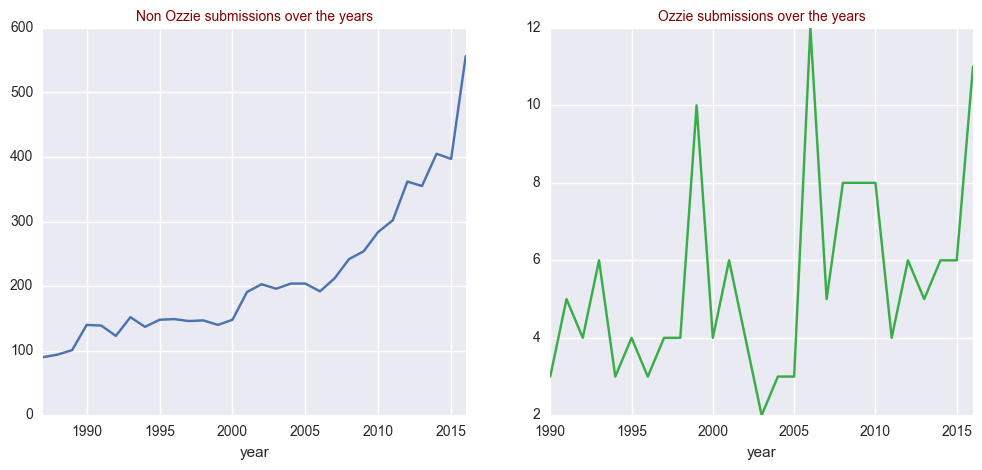

In [27]:
# set common parameters
fig = plt.figure(figsize=(12,5));   
sns.set_color_codes("muted")

# start painting!
ax0 = fig.add_subplot(1,2,1);
ax1 = fig.add_subplot(1,2,2);

df_papers.loc[df_papers.ozzie == 0,['id','year']].groupby(by='year').count().plot(kind="line", ax = ax0)
df_papers.loc[df_papers.ozzie == 1,['id','year']].groupby(by='year').count().plot(kind="line", ax = ax1, color = sns.xkcd_rgb["medium green"])

ax0.set_title("Non Ozzie submissions over the years",fontsize=10,color="maroon")
ax1.set_title("Ozzie submissions over the years",fontsize=10,color="maroon")
ax0.legend_.remove(), ax1.legend_.remove()

I thought it'd be better to put these 2 side by side, rather than as 2 lines in the same plot because the axes would be all messed up and we wouldnt get a true picture of the trends.

#### whats the deal with the event type?

I found a link on reddit here (https://www.reddit.com/r/MachineLearning/comments/3thfgz/nips/cx67pjt/) that tells us more about NIPS event types:<br>
Tutorials are multi-track, you generally pick one per time slot. These are, at their best, opinionated introductions to a particular area of inquiry; at their worst, a particular speaker's research highlights reel.<br>
The conference oral presentations are single track, there are no oral presentations scheduled at the same time as one another. There are "spotlight" sessions which are several 5 minute presentations back to back in roughly the same length of slot that one oral presentation would get. The poster sessions are one big, loud, overcrowded science fair type thing held in the evenings of the main conference.<br>
The workshops are more niche meetings that are scheduled separately and in parallel. Many people come just for the workshops, or rather for a particular workshop related to their area of interest; this applies to a lot of neuroscience folks who have long since abandoned the main conference (ironically given the first word of the name).

In [28]:
df_papers[df_papers.ozzie == 1].event_type.value_counts()

             119
Poster        22
Spotlight      5
Oral           1
Name: event_type, dtype: int64

Most of them are unclassified. So I wouldnt read too much into this just yet.

#### how big are the papers?

[]

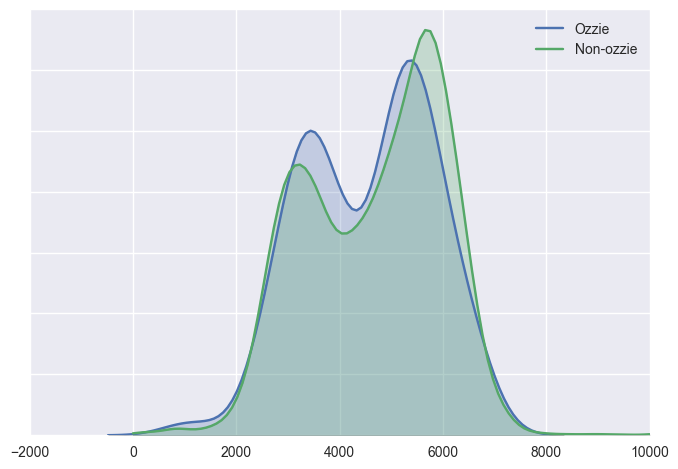

In [29]:
fig, ax = plt.subplots()
sns.kdeplot(df_papers.loc[df_papers.ozzie == 1,'paper_length'], shade=True, ax = ax)
sns.kdeplot(df_papers.loc[df_papers.ozzie == 0,'paper_length'], shade=True, ax = ax, clip=(0,10000))
ax.legend(labels=['Ozzie','Non-ozzie'], loc = 'best')
ax.yaxis.set_ticklabels([])

Looks like Ozzie papers are comparable to papers from around the world, being only slightly smaller.

## Close the connection

In [30]:
cnx.close()

FIN.